# Plant Classifier
 - Data from kaggle
 - simple neural net with numpy

In [1]:
# Import Libraries
import os, random, math
import numpy as np
import cv2

from matplotlib import pyplot as plt
from PIL import Image

## Load and Analyse Data

In [2]:
data_path = "dataset"
classes = os.listdir(data_path)
print(classes)

['broadleaf', 'grass', 'soil', 'soybean']


,Shape:  (206, 232)


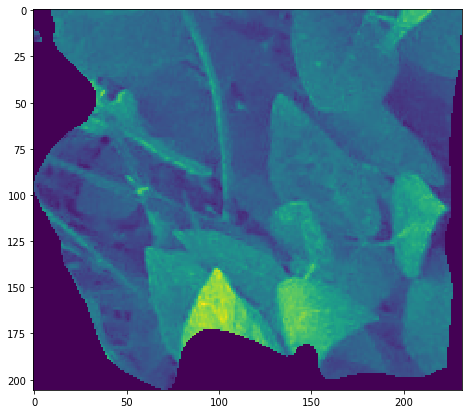

In [7]:
# Plot random image
img = cv2.imread(data_path+'/'+classes[3]+'/'+random.choice(os.listdir(data_path+'/'+classes[0]+'/')),0)
#cv2.imshow("testbild", img)
plt.figure(figsize=(20, 7))
imgplot = plt.imshow(img)
print("Shape: ", img.shape)

In [8]:
#Analysze sizes of pictures
height_sum = []
width_sum = []
for im_class in classes:
    for i in os.listdir(data_path+'/'+im_class):
        #print(i)    #Data_sum.append()
        img = cv2.imread(data_path+'/'+im_class+'/'+i,0)
        height, width = img.shape[:2]
        height_sum.append(height)
        width_sum.append(width)
        
# Analyse sizes of pictures
print("Min height: ", min(height_sum), "  Max height: ",max(height_sum))
print("Min width: ", min(width_sum), "  Max width: ",max(width_sum))          

In [10]:
#Load Data 

Train_data = []
Train_labels = []
label = 0

for im_class in classes:
    max_count =0 
    for i in os.listdir(data_path+'/'+im_class):

        img = cv2.imread(data_path+'/'+im_class+'/'+i,0)
        img_r = cv2.resize(img,(100,100))
        
        #Flatten list for input in neural network      
        flat_list = []
        for sublist in img_r:
            for item in sublist:
                flat_list.append(item)
        
        Train_data.append(flat_list)
        Train_labels.append(label)
        max_count = max_count+1
        if max_count >2500:
            break
    label = label+1
    
# Check sizes
print(len(Train_labels))
print(len(Train_data))   

8694
8694


In [13]:
# Convert to array
tda = np.asarray(Train_data)
print(tda.shape)
tdl = np.asarray(Train_labels)
print(tdl.shape)

(8694, 10000)
(8694,)


In [14]:
# Splint in train and Test data
# 20 Datasets for testing
test_number = np.random.choice(np.arange(tda.shape[0]),20, replace=False)
test_data = tda[test_number]
test_label = tdl[test_number]

# Delete obsolte arrays to save memory
tda = np.delete(tda, test_number, axis = 0)
tdl = np.delete(tdl, test_number)

# Print shapes
print(tda.shape)
print(tdl.shape)
print(test_data.shape)
print(test_label.shape)

(8674, 10000)
(8674,)
(20, 10000)
(20,)


In [15]:
# Compute the mean image
tda = tda.astype('float64')
test_data = test_data.astype('float64')
mean_image = np.mean(tda, axis=0) # axis=0. stack horizontally
# Subtract the mean image from train and test data 

tda -= mean_image
test_data -= mean_image 

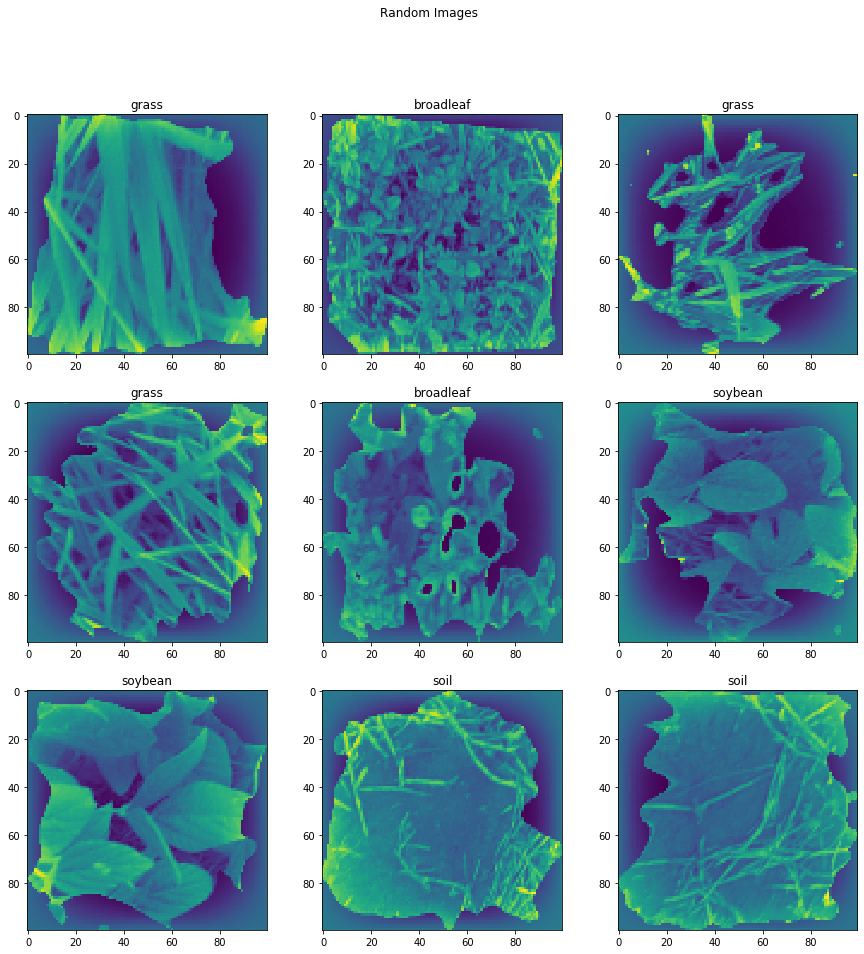

In [95]:
# Printing random images
plt.figure(figsize=(15, 15))
plt.suptitle("Random Images")
for i in range(9):  
    ri = np.random.randint(len(tda),size = 1)
    imgname = tda[int(ri)]
    imgname = imgname.reshape(100,100)   
    imtit = classes[tdl[int(ri)]]
    plt.subplot(331 + i)
    plt.title(imtit)
    imgplot = plt.imshow(imgname)

## Definition of Neural Network

In [28]:
def sigmoid(x):
    if x <0: #Avoids overflow if x<0
        return 1-1 / (1+math.exp(x))
    return 1 / (1+math.exp(-x))
         
sigmoid_v = np.vectorize(sigmoid)

In [83]:
# Create Neural net
# 1 Hidden Layer1
# Input: 10.000; Hidden 1 : 1000; Output: 4

# Path Input * W1 = H1; H1*W2 = Out

class model:
    
    Input_layers = 10000
    Hidden_layers1 = 150 #200
    Out_layers = 4
 

    # Init random weights for layers
    w1 = 1e-3 * np.random.rand(Input_layers, Hidden_layers1)
    w2 = 1e-3 * np.random.rand(Hidden_layers1,Out_layers)
    b1 = np.zeros(Hidden_layers1)
    b2 = np.zeros(Out_layers)


    
   
    def relu(self, z):
        return np.maximum(0, z)
   
    
    
    def predict(self, X):
        Y_pred = None
        H1 = sigmoid_v(X.dot(self.w1) + self.b1)
        #H1 = self.relu(X.dot(self.w1) + self.b1)
        Result = H1.dot(self.w2) + self.b2
        #Result = sigmoid_v(Result)
        Y_pred = np.argmax(Result, axis=1)
        return Y_pred
    
    
    
    def loss(self, X,reg, Y):
        N=X.shape[0]
        # Calculate FW-Path
        #evtl. x. flatten rein
        H1 =np.dot(X,self.w1)+self.b1
        #H1 = sigmoid_v(H1)
        H1 = self.relu(H1)
        Result = np.dot(H1,self.w2)+self.b2
        #Result =sigmoid_v(Result)
        
        
        Result = Result - Result.max()
        Result = np.exp(Result)
        Result_sum = np.sum(Result, axis=1)

      
        softmax = Result /  Result_sum.reshape(N,1)
        
        loss = -1.0 * np.sum(np.log(softmax[range(N), Y]))
        loss /= N       
        
        #Add Regularization to avoid overfitting
        loss += reg * np.sum(self.w1 * self.w1) 
        loss += reg * np.sum(self.w2 * self.w2) 
        
        
        #loss
        
        
        
        grads = {}
        correct_class_scores = Result[range(N), Y]
        softmax[range(N), Y] = -1.0 * (Result_sum - correct_class_scores) / Result_sum
        softmax /= N

        grads['w2'] = H1.T.dot(softmax)
        grads['b2'] = np.sum(softmax, axis=0)
        grads['w2'] += reg * 2* self.w2 
        
        hidden = softmax.dot(self.w2.T)

        grads['w1'] = X.T.dot(hidden)
       
    
        grads['b1'] = np.sum(hidden, axis=0)
        grads['w1'] += reg *2 *self.w1
                           
         
        return loss, grads
    
      

    batch_size =300   
    epochs = 2001
    
    
    def train(self, tda,tdl,alpha,reg):
        N=tda.shape[0]
        
        loss_hist = []
        train_acc_hist = []
        iteration_per_epoch = max(N / self.batch_size, 1)
        
        for it in range(self.epochs):

            # Crate Batch: Random array of batch size
            sampling = np.random.choice(np.arange(N),self.batch_size, replace=False)
            #print(sampling)
            X_batch = tda[sampling]
            Y_batch = tdl[sampling]
            
            # Compute loss and gradients
            
            loss, grads = self.loss(X_batch,reg, Y_batch)
            
            if loss > 2:
                loss_hist.append(2)
            else:
                loss_hist.append(loss)
            
            self.w1 += -1.0 * alpha * grads['w1']
            self.b1 += -1.0 * alpha * grads['b1']
            self.w2 += -1.0 * alpha * grads['w2']
            self.b2 += -1.0 * alpha * grads['b2']
            
            train_acc = (self.predict(X_batch) == Y_batch).mean()
                
            train_acc_hist.append(train_acc)          
            
            if it % 100 == 0:
                print('Iteration: %d / %d | Loss: %f | Accuracy: %f' % (it+1, self.epochs, loss, train_acc))
                alpha = alpha * 0.9


        return [loss_hist, train_acc_hist]     

## Training and Analysis

In [84]:
# With the loops you can try different alpha and regulation parameters.
for a in [8e-4]:
    for r in [0.005]:
        print("Alpha: ", a, "Lambda: ", r)
        model1 = model()
        stats = model1.train(tda, tdl,a,r)        

Alpha:  0.0008 Lambda:  0.005
Iteration: 1 / 2001 | Loss: 1.408816 | Accuracy: 0.326667


C:\Users\stkru\.conda\envs\ml_course\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


Iteration: 101 / 2001 | Loss: 1.316617 | Accuracy: 0.366667
Iteration: 201 / 2001 | Loss: 1.220648 | Accuracy: 0.386667
Iteration: 301 / 2001 | Loss: 1.180027 | Accuracy: 0.480000
Iteration: 401 / 2001 | Loss: 1.162918 | Accuracy: 0.500000
Iteration: 501 / 2001 | Loss: 1.184734 | Accuracy: 0.533333
Iteration: 601 / 2001 | Loss: 1.078656 | Accuracy: 0.476667
Iteration: 701 / 2001 | Loss: 1.049760 | Accuracy: 0.486667
Iteration: 801 / 2001 | Loss: 0.975690 | Accuracy: 0.530000
Iteration: 901 / 2001 | Loss: 0.979364 | Accuracy: 0.543333
Iteration: 1001 / 2001 | Loss: 0.963455 | Accuracy: 0.563333
Iteration: 1101 / 2001 | Loss: 0.938978 | Accuracy: 0.550000
Iteration: 1201 / 2001 | Loss: 0.931828 | Accuracy: 0.580000
Iteration: 1301 / 2001 | Loss: 0.823518 | Accuracy: 0.633333
Iteration: 1401 / 2001 | Loss: 0.811691 | Accuracy: 0.626667
Iteration: 1501 / 2001 | Loss: 0.819593 | Accuracy: 0.606667
Iteration: 1601 / 2001 | Loss: 0.762860 | Accuracy: 0.613333
Iteration: 1701 / 2001 | Loss: 0.

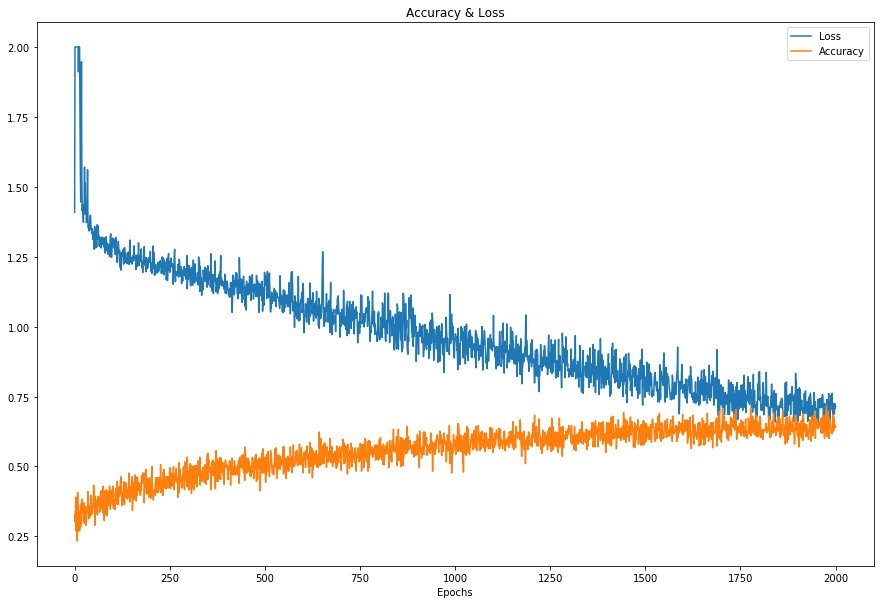

In [85]:
plt.figure(figsize = (15,10))
plt.plot(stats[0], label = "Loss")
plt.plot(stats[1], label = "Accuracy")
plt.title("Accuracy & Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

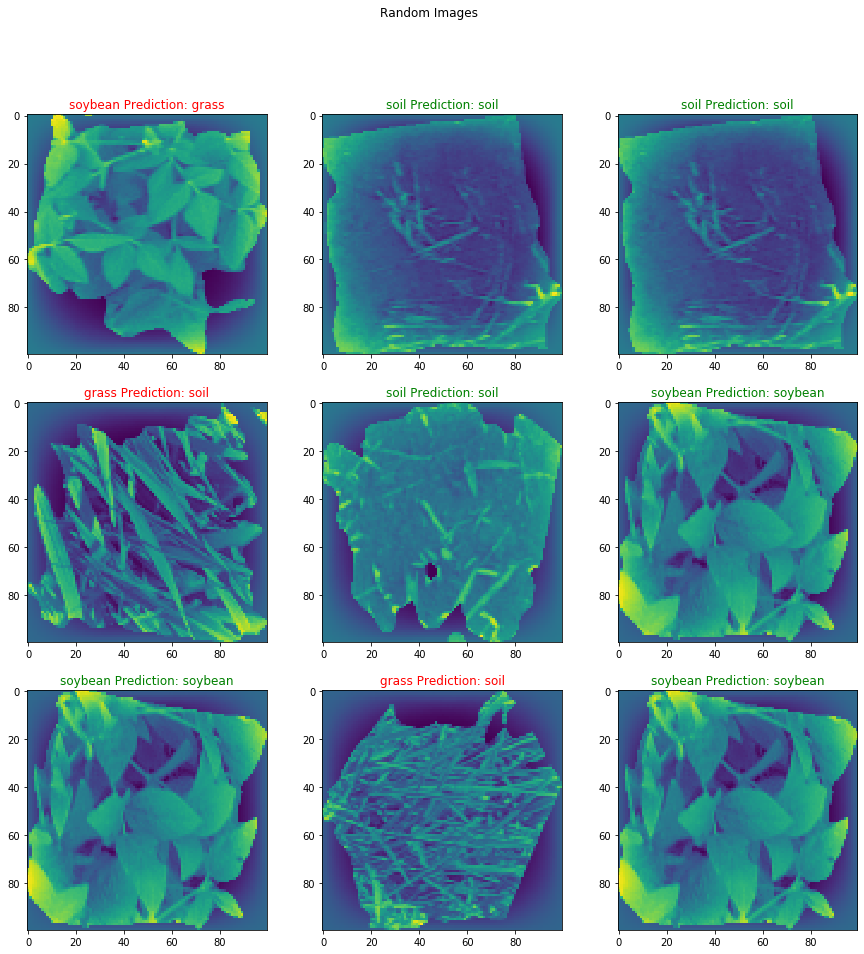

In [97]:
# Predicting random images


plt.figure(figsize=(15, 15))
plt.suptitle("Random Images")
for i in range(9):  
    ri = np.random.randint(len(test_data),size = 1)
    imgname = test_data[int(ri)]
    im_pred = imgname[np.newaxis,:] # Image for Prediction, add dimension to fit prediction funciton
    
    prediction = model1.predict(im_pred)
    pred_class = classes[int(prediction)] 
    is_class = classes[test_label[int(ri)]]
    imgname = imgname.reshape(100,100)   

    plt.subplot(331 + i)
    plt.title(imtit)
    imgplot = plt.imshow(imgname)
    
    imtit = is_class + " Prediction: " + pred_class
    

    if is_class == pred_class:
        plt.title(imtit, color ="g")
    else:
        plt.title(imtit, color ="r")
